### Empirical Bayesian Forests

In this quick note, we show how  you can use spark to facilitate our EBF strategy: fit a trunk, and use this to map data to branches for full forest fits.  The data example here is really small -- 20k observations -- and the unnecessary spark overhead probably slows things down, but you can see the mechanics.  We use the TaddyLab branch of spark at  https://github.com/TaddyLab/spark/tree/ebayes, which just adds the getLeafID functionality to MLlib decision trees necessary for obtaining branch IDs.

Our strategy here is that we fit the trunk in distribution, use the resulting branch IDs to define a `groupByKey` operation on all observations, and then apply `scikit learn` in-memory RandomForests on each branch.  Since group-by-key ensures that members of the same branch are on the same partition (we show this in the example), this last step should require no more computation than if you were running `scikit learn` on a single machine.  

For truly Big Data (i.e., if you have memory constraints) then you will need to be careful how you organize these steps -- the solution will be specific to your setup.  For example, you may wish to subsample the data to fit the original trunk (which is fine, as in http://arxiv.org/abs/1502.02312, since the trunk is relatively stable).  Most importantly, you will need to ensure that each branch contains a small enough portion of the data that it can be analyzed as you've specified (using scikit learn or MLlib or something else).  

In all cases, you may be able to increase efficiency by using smaller branch-datasets while increasing parallelization across tree-fitting; we have no theoretical rule for what is optimal here and suggest experimentation.

---
first, we'll start spark

In [1]:
import os
import sys

spark_home = os.environ['SPARK_HOME']
sys.path.insert(0, spark_home + "/python/")
sys.path.insert(0, os.path.join(spark_home, 'python/lib/py4j-0.8.2.1-src.zip'))

# Initialize PySpark to predefine the SparkContext variable 'sc'
execfile(os.path.join(spark_home, 'python/pyspark/shell.py'))

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 1.6.0-SNAPSHOT
      /_/

Using Python version 2.7.10 (default, May 28 2015 17:02:03)
SparkContext available as sc, SQLContext available as sqlContext.


add a function to read the csv data lines

In [2]:
import csv
import StringIO
from pyspark.mllib.regression import LabeledPoint

def loadRecord(line):
    """Parse a CSV line"""
    input = StringIO.StringIO(line)
    reader = csv.reader(input)
    row = map(float, reader.next())
    return LabeledPoint(row[-1],row[:-1]) 


and a bunch of functions to translate from the MLLIB DebugString to a nice dot file for plotting

In [3]:
import re
from IPython.display import Image

def tree2dict(tstr, covariates, i=0):
    m = re.search(r"Predict: (-*\d+.\d+)", tstr[i])
    if m is not None:
        return {i-1:round(float(m.group(1)),2)}
    else:
        m = re.search(r"If \(feature (\d+) <= (-*\d+.\d+)", tstr[i])
        if m is not None:
            label = covariates[int(m.group(1))] + ' > ' + m.group(2)
            left = i + 1
            right = [re.search(
                    "Else \(feature %s > %s"%(m.group(1),m.group(2)),t)
                     for t in tstr]
            right = [j for j,r in enumerate(right) if r is not None and j > i][0]+1
            return {i-1:{
                    'label':label, 
                    'left':tree2dict(tstr,covariates,left), 
                    'right':tree2dict(tstr,covariates,right)}}
        else:
            if i < len(tstr)-1:
                return tree2dict(tstr,covariates,i+1)

def writenode(t,fout):
    i = t.keys()[0]
    if type(t[i]) is float:
        fout.write('%d [label = "%.2f", shape="oval", color="darkgreen"] ;\n'%(i,t[i]))
    else:
        fout.write('%d [label = "%s", shape="box", color="brown"] ;\n'%(i,t[i]['label']))
        fout.write('%d -> %d ;\n'%(i,t[i]['left'].keys()[0]))
        fout.write('%d -> %d ;\n'%(i,t[i]['right'].keys()[0]))
        writenode(t[i]['left'],fout)
        writenode(t[i]['right'],fout)

def showtree(tree, covariates, name="tree"):
    tstr = tree.toDebugString().strip("\n").split("\n")
    fout = open("%s.dot"%name,'w')
    tdict = tree2dict(tstr, covariates)
    fout.write("digraph Tree {\n")
    writenode(tdict,fout)
    fout.write("}\n")
    fout.close()
    os.system("dot -Tpng %s.dot -o %s.png"%(name,name))


Now we **start the analysis**. First, read the data.

In [4]:
data = sc.textFile("data/CAhousing.csv")
header = data.first() 
data = data.filter(lambda x:x !=header)   
data = data.map(loadRecord)
data.persist()

var = header.split(",")
for i,j in enumerate(var):
    print "%d: %s" % (i,j)

n = data.count()
print "\n", n, "observations like", data.first()


0: longitude
1: latitude
2: housingMedianAge
3: totalRooms
4: totalBedrooms
5: population
6: households
7: medianIncome
8: medianHouseValue

20640 observations like (452600.0,[-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252])


Use MLlib to train a decision tree.

In [5]:
# Train a DecisionTree model.
from pyspark.mllib.tree import DecisionTree

#  Empty categoricalFeaturesInfo indicates all features are continuous.
trunk = DecisionTree.trainRegressor(data, categoricalFeaturesInfo={},
                                    impurity='variance', minInstancesPerNode=3500)

print trunk.toDebugString()

DecisionTreeModel regressor of depth 3 with 9 nodes
  If (feature 7 <= 4.9792)
   If (feature 7 <= 3.0375)
    If (feature 1 <= 34.57)
     Predict: 156173.119201726
    Else (feature 1 > 34.57)
     Predict: 114653.23790117167
   Else (feature 7 > 3.0375)
    If (feature 2 <= 26.0)
     Predict: 185471.87712206953
    Else (feature 2 > 26.0)
     Predict: 224001.66975373606
  Else (feature 7 > 4.9792)
   Predict: 327413.6122359155



_Note that if you re-run each tree will be slightly different because for continuous inputs spark splits on 32 quantiles of a random subsample of data._

Here's a plot of our trunk (which stops at 3500 observations per branch)

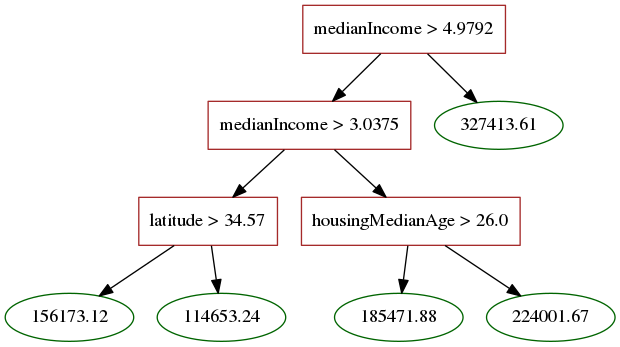

In [6]:
showtree(trunk, var, "cahtree")
Image(filename="cahtree.png")

Once we have the trunk, we can use it to define a branch **key** for each observation.  We zip it together with the observations to create a key-value RDD.

In [7]:
leaf = trunk.getLeafID(data.map(lambda x: x.features))
leafval = leaf.zip(data)
## below seems to me to be better practice but it's not valid from python API.
# leafval = data.map(lambda x: (cahtree.getLeafID(x.features), x))

In [8]:
# some sanity checks
print leafval.first() # first key-value pair
print data.first() # first value
print trunk.getLeafID(data.first().features) # first key

(3, LabeledPoint(452600.0, [-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252]))
(452600.0,[-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252])
3


Now we use **groupByKey** to shuffle the data and group into an RDD that holds an iterator corresponding to each branch.  You'll often see warnings agains using groupByKey, since its re-shuffle is unnecessary for many common aggregations, but it is perfect for what we want to do here: collect data subsets for input to a communication intensive algorith.

In [9]:
branches = leafval.groupByKey()

To understand what happened here, take a look at the results of a `glom` on the elements of `branches` that groups them by partition.   Each branch of data is an iterable on a single partition.

In [10]:
branches.glom().collect()

[[(8, <pyspark.resultiterable.ResultIterable at 0x7fa815598d10>),
  (10, <pyspark.resultiterable.ResultIterable at 0x7fa81526efd0>)],
 [(3, <pyspark.resultiterable.ResultIterable at 0x7fa814f22d10>),
  (9, <pyspark.resultiterable.ResultIterable at 0x7fa814b94190>),
  (11, <pyspark.resultiterable.ResultIterable at 0x7fa8147eda90>)]]

In [11]:
branches.mapValues(len).glom().collect() # the number of observations in each branch

[[(8, 3708), (10, 3711)], [(3, 4544), (9, 3926), (11, 4751)]]

Finally, fit forests on each branch.  There is a lot of freedom in how you do this; if your branches are small enough you can just bring the data into memory and apply speedy scikit learn forests.  This is what we do here.  You can also adjust the number of workers per branch, with the caveat that more workers requires more memory (and thus smaller branches).

Alternatively, you can use MLlib randomForests to fit the forests at each branch and thus avoid bringing the branch datasets into memory.  There's no easy way to do this in python, but from scala (which is what you'll likely be using anyways if submitting jobs on a Hadoop cluster) you can first create and `Array` of `RDD`s (one for each branch) and then -- possibly in parallel via `.par` -- use `.map` to apply the MLlib `randomForest` routines.  


Our forest fitting function; takes a labeled point iterator as input

In [12]:
import numpy as np
import scipy as sp
from sklearn import ensemble

def fitforest(lpi):
    y = [p.label for p in lpi]
    x = np.array([p.features for p in lpi])
    f = ensemble.RandomForestRegressor(n_estimators=200,min_samples_leaf=100,n_jobs=4)
    f.fit(x, y)
    return f


And now map values (this preserves the partitioning) to the forest fitter.


In [13]:
caf = branches.mapValues(fitforest)
# we get n_branch random forests
caf.collect()

[(8, RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
             max_features='auto', max_leaf_nodes=None, min_samples_leaf=100,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, n_jobs=4, oob_score=False, random_state=None,
             verbose=0, warm_start=False)),
 (10, RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
             max_features='auto', max_leaf_nodes=None, min_samples_leaf=100,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, n_jobs=4, oob_score=False, random_state=None,
             verbose=0, warm_start=False)),
 (3, RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
             max_features='auto', max_leaf_nodes=None, min_samples_leaf=100,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, n_jobs=4, oob_score=False, random_state=None,
             verbose=0, warm_

And we're done!  For example, we can now use the trees to 'predict' response values.

In [14]:
# broadcast the forests to be on each node (collectAsMap creates a dictionary)
broadcastCAF = sc.broadcast(caf.collectAsMap())
broadcastCAF.value

def predforest(k,p):
    x = [i.features for i in p]
    yhat = broadcastCAF.value[k].predict(x)
    return yhat
    


for true Big Data you actually need to be as careful with memory management here as you were when fitting.  We'll use the already grouped-by-key branches.

In [15]:
fits = branches.map(lambda kb: (kb[0], predforest(kb[0],kb[1])))

And finally, plot the [ in-sample ] fit.

In [16]:
yhat = fits.collectAsMap()
y = branches.map(lambda kb: (kb[0], [p.label for p in kb[1]])).collectAsMap()


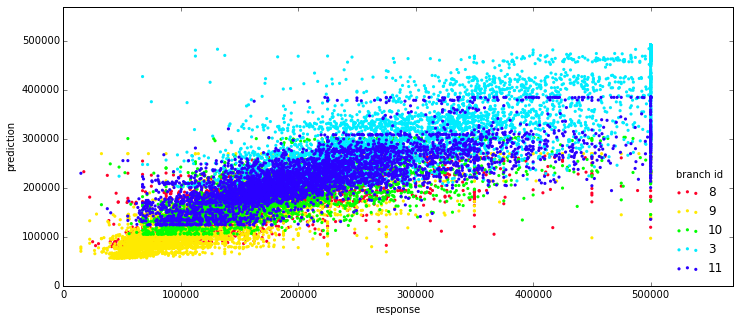

In [17]:

import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('figure', figsize=(12,5))
plt.rc('figure.subplot', wspace=.33)

K = len(yhat.keys())
for i in range(K):
    k = yhat.keys()[i]
    plt.scatter(y[k], yhat[k], c=plt.cm.gist_rainbow(i/float(K)), label=k,s=10,edgecolors='none')
plt.xlabel("response")
plt.ylabel("prediction")
plt.xlim(0,570000)
plt.ylim(0,570000)
plt.legend(frameon=False,loc=4, title="branch id")
